In [1]:
import pickle
import os 
import netCDF4 as netcdf
import skimage
import numpy as np
import torch 
import matplotlib.pyplot as plt

with open('ssp585_time_series.pkl', 'rb') as f:
    dic_ssp585 = pickle.load(f)

# Get the list of all files and directories
path = "/net/atmos/data/cmip6-ng/tos/ann/g025"
dir_list = os.listdir(path)

print("Files and directories in '", path, "' :")

list_model = []
list_forcing = []

for idx, file in enumerate(dir_list):

    file_split = file.split("_")
    
    # extract model names
    model_name = file_split[2]
    forcing = file_split[3]
    run_name = file_split[4]
    
    list_model.append(model_name)
    list_forcing.append(forcing)
    
model_names = list(set(list_model))
forcing_names = list(set(list_forcing))


# define the file
file = '/net/h2o/climphys3/simondi/cope-analysis/data/erss/sst_annual_g050_mean_19812014_centered.nc'

# read the dataset
file2read = netcdf.Dataset(file,'r')

# load longitude, latitude and sst monthly means
lon = np.array(file2read.variables['lon'][:])
lat = np.array(file2read.variables['lat'][:])
sst = np.array(file2read.variables['sst'])

# define grid
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')

time_period = 33
grid_lat_size = lat.shape[0]
grid_lon_size = lon.shape[0]

# first filter out the models that do not contain ensemble members 
dic_reduced_ssp585 = {}

for m in list(dic_ssp585.keys()):
    if len(dic_ssp585[m].keys()) > 2:
        dic_reduced_ssp585[m] = dic_ssp585[m].copy()
        for idx_i, i in enumerate(dic_ssp585[m].keys()):
            dic_reduced_ssp585[m][i] = skimage.transform.downscale_local_mean(dic_reduced_ssp585[m][i],(1,2,2))
            lat_size = dic_reduced_ssp585[m][i][0,:,:].shape[0]
            lon_size = dic_reduced_ssp585[m][i][0,:,:].shape[1]

######## Store Nan indices 

nan_idx = []
for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    for idx_i,i in enumerate(dic_reduced_ssp585[m].keys()):    

        nan_idx_tmp = list(np.where(np.isnan(dic_reduced_ssp585[m][i][0,:,:].ravel())==True)[0])        
        nan_idx = list(set(nan_idx) | set(nan_idx_tmp))

notnan_idx = list(set(list(range(lon_size*lat_size))) - set(nan_idx))

############################


# second, for each model we compute the anomalies 
dic_processed_ssp585 = {}

import numpy as np

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_processed_ssp585[m] = dic_reduced_ssp585[m].copy()
    
    mean_ref_ensemble = 0
    for idx_i, i in enumerate(dic_reduced_ssp585[m].keys()):
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')

        if idx_i == 0:
            mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())
        else:
            mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())

    for idx_i, i in enumerate(dic_processed_ssp585[m].keys()):
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')
        dic_processed_ssp585[m][i] = y_tmp - mean_ref_ensemble


# compute the forced response
dic_forced_response_ssp585 = dict({})

for idx_m,m in enumerate(dic_reduced_ssp585.keys()):
    dic_forced_response_ssp585[m] = dic_reduced_ssp585[m].copy()

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):
        
        y_tmp = dic_reduced_ssp585[m][i][131:164,:,:].copy().reshape(time_period, lat_size*lon_size)
        y_tmp[:,nan_idx] = float('nan')
        
        if idx_i == 0:
            mean_spatial_ensemble = np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())
        else:
            mean_spatial_ensemble += np.nanmean(y_tmp,axis=1)/ len(dic_forced_response_ssp585[m].keys())

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):        
        dic_forced_response_ssp585[m][i] = mean_spatial_ensemble - np.nanmean(mean_spatial_ensemble)

y_forced_response = {}
x_predictor = {}

for idx_m,m in enumerate(dic_processed_ssp585.keys()):
    y_forced_response[m] = {}
    x_predictor[m] = {}

    for idx_i, i in enumerate(dic_forced_response_ssp585[m].keys()):       
        y_forced_response[m][i] = dic_forced_response_ssp585[m][i]
        x_predictor[m][i] = dic_processed_ssp585[m][i]
        x_predictor[m][i][:,nan_idx] = float('nan')


# compute the variance
variance_processed_ssp585 = {}
std_processed_ssp585 = {}
for idx_m,m in enumerate(x_predictor.keys()):
    variance_processed_ssp585[m] = {}
    arr_tmp = np.zeros((len(x_predictor[m].keys()),33))
    
    for idx_i, i in enumerate(list(x_predictor[m].keys())):
        arr_tmp[idx_i,:] = np.nanmean(x_predictor[m][i],axis=1)

    arr_tmp_values = np.zeros((len(x_predictor[m].keys()),33))
    for idx_i, i in enumerate(x_predictor[m].keys()):
        arr_tmp_values[idx_i,:] = (y_forced_response[m][i] - arr_tmp[idx_i,:])**2

    # variance_processed_ssp585[m] = torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0)
    variance_processed_ssp585[m] = torch.mean(torch.nanmean(torch.from_numpy(arr_tmp_values),axis=0))

Files and directories in ' /net/atmos/data/cmip6-ng/tos/ann/g025 ' :


/tmp/ipykernel_4843/2547453487.py:94: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble = np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())
/tmp/ipykernel_4843/2547453487.py:96: RuntimeWarning: Mean of empty slice
  mean_ref_ensemble += np.nanmean(y_tmp,axis=0)/ len(dic_processed_ssp585[m].keys())


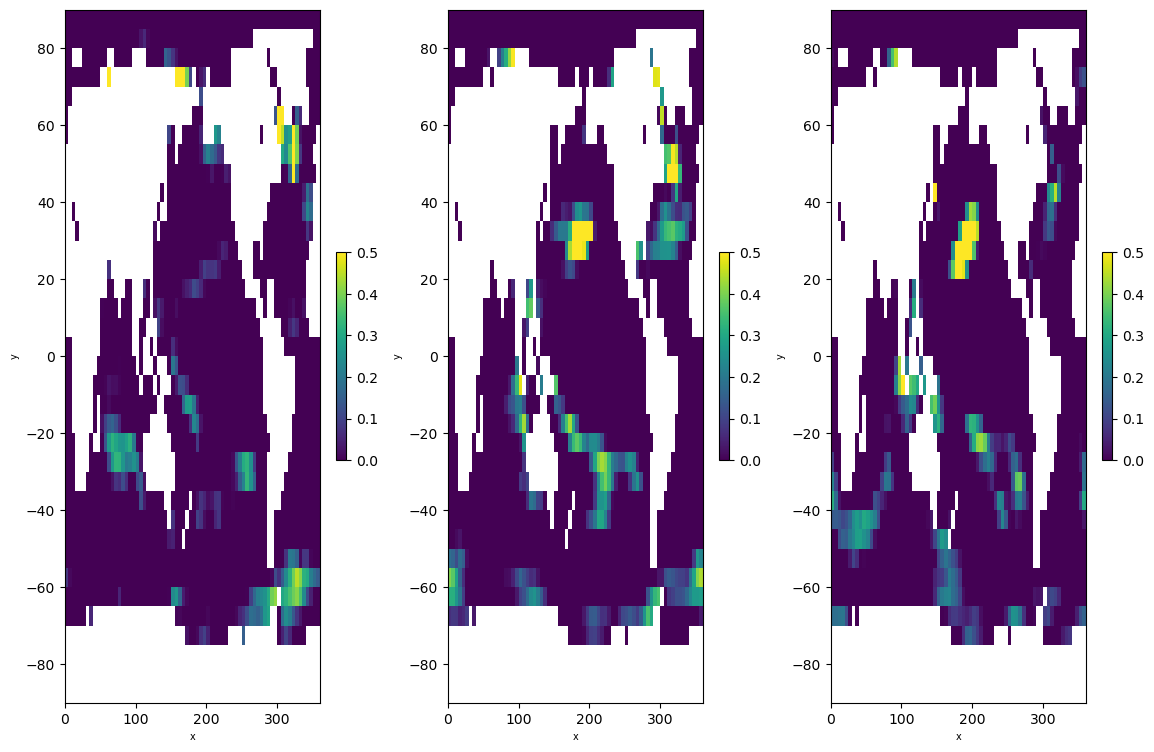

In [2]:
# define beta to plot
idx_m = 2
idx_run = 0

processed_model_names = list(x_predictor.keys())
m = processed_model_names[idx_m]
lst_run = list(x_predictor[m].keys())
r = lst_run[idx_run]


sst0 = x_predictor[m][r][0]
sst0[nan_idx] = float('nan')
sst0 = sst0.reshape(grid_lat_size,grid_lon_size)


sst1 = x_predictor[m][r][1]
sst1[nan_idx] = float('nan')
sst1 = sst1.reshape(grid_lat_size,grid_lon_size)

sst2 = x_predictor[m][r][2]
sst2[nan_idx] = float('nan')
sst2 = sst2.reshape(grid_lat_size,grid_lon_size)

fig0 = plt.figure(figsize=(14,9))           

ax0 = fig0.add_subplot(1, 3, 1)        
# ax0.set_title(r'$\beta \geq 0$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,sst0,vmin=-0.00,vmax = 0.5)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax0 = fig0.add_subplot(1, 3, 2)        
# ax0.set_title(r'$\beta \leq 0$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,sst1,vmin=0.00,vmax = 0.5)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


ax0 = fig0.add_subplot(1, 3, 3)        
# ax0.set_title(r'$\beta \leq 0$', size=7,pad=3.0)
im0 = ax0.pcolormesh(lon_grid,lat_grid,sst2,vmin=0.00,vmax = 0.5)
plt.colorbar(im0, ax=ax0, shrink=0.3)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)


plt.savefig("poster_figures/time_series_images.png")
plt.show()

In [5]:
# define beta to plot
idx_m = 2

processed_model_names = list(x_predictor.keys())
m0 = processed_model_names[idx_m]

ll = list(x_predictor[m0].values())
ll = [np.nanmean(i,axis=1) for i in ll]


times_to_plot = np.arange(1981,2014)
sst_to_plot0 = np.array(ll)
sst_mean_to_plot0 = np.mean(ll,axis=0)


# define beta to plot
idx_m = 3

processed_model_names = list(x_predictor.keys())
m1 = processed_model_names[idx_m]

ll = list(x_predictor[m1].values())
ll = [np.nanmean(i,axis=1) for i in ll]

times_to_plot = np.arange(1981,2014)
sst_to_plot1 = np.array(ll)
sst_mean_to_plot1 = np.mean(ll,axis=0)

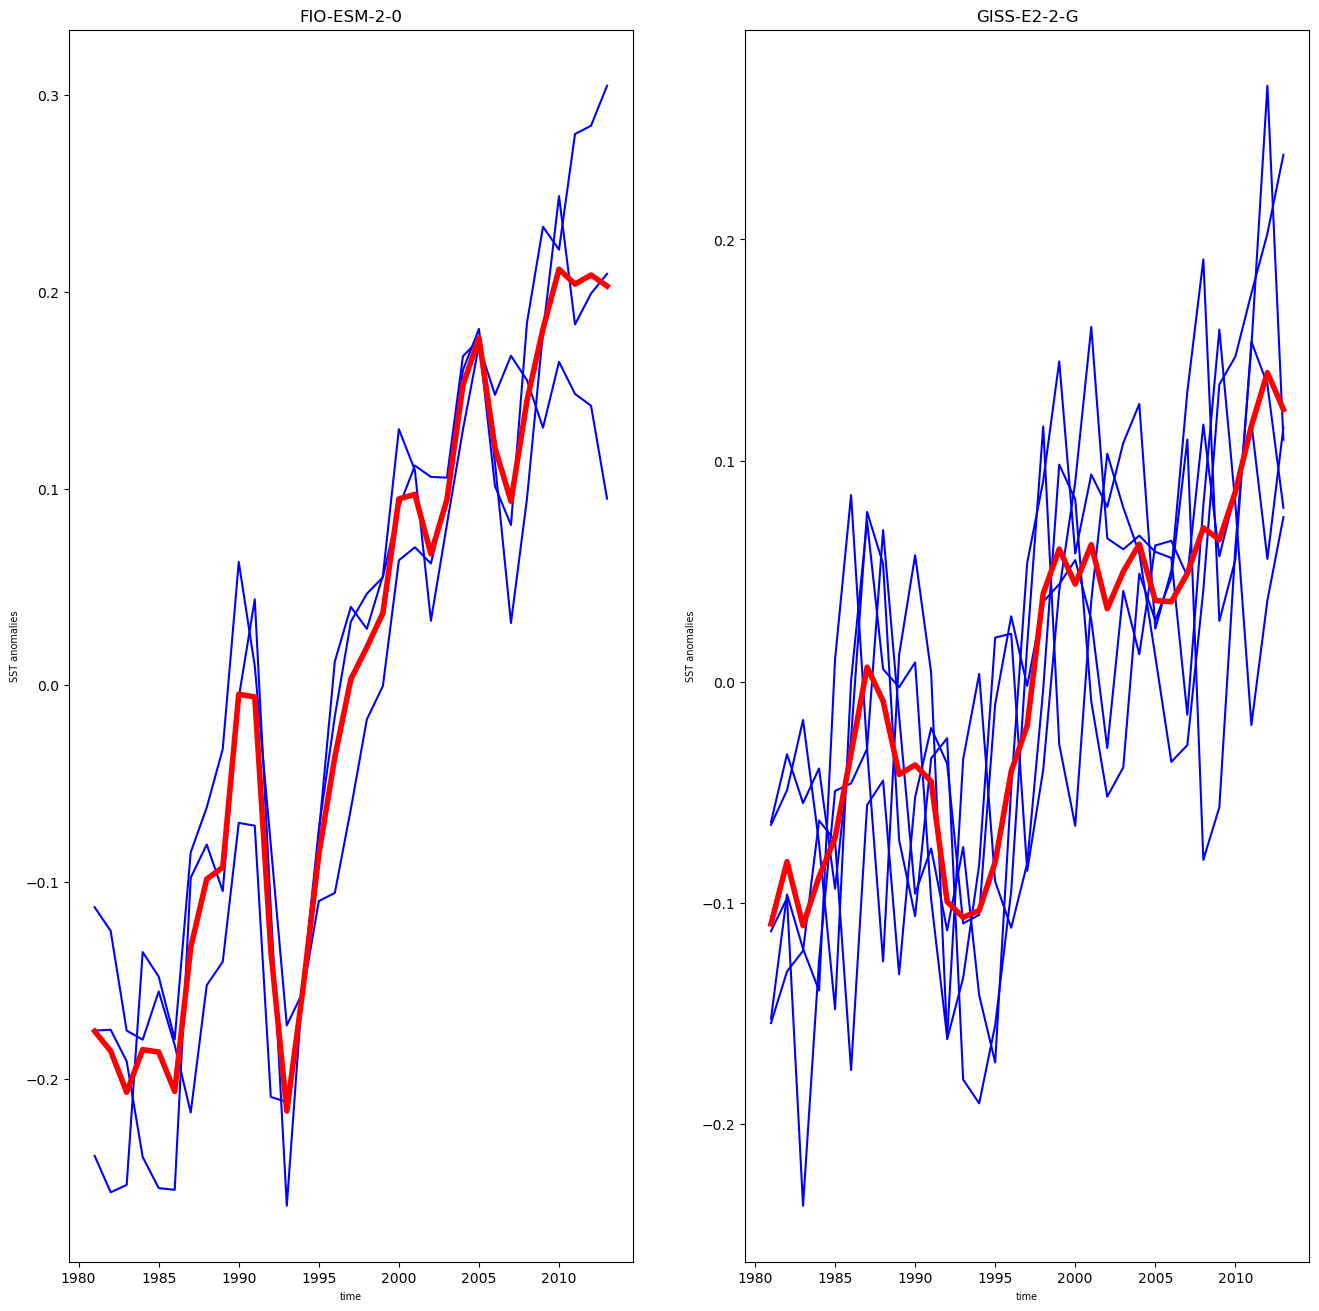

In [7]:
fig0 = plt.figure(figsize=(16,16))           

ax0 = fig0.add_subplot(1, 2, 1)  
for i in range(sst_to_plot0.shape[0]):
    ax0.plot(times_to_plot,sst_to_plot0[i,:],'b')
ax0.plot(times_to_plot,sst_mean_to_plot0,'r',linewidth=4)
ax0.set_title(m0)
ax0.set_xlabel(r'time', size=7)
ax0.set_ylabel(r'SST anomalies', size=7)

ax0 = fig0.add_subplot(1, 2, 2)  
for i in range(sst_to_plot1.shape[0]):
    ax0.plot(times_to_plot,sst_to_plot1[i,:],'b')
ax0.plot(times_to_plot,sst_mean_to_plot1,'r',linewidth=4)
ax0.set_title(m1)
ax0.set_xlabel(r'time', size=7)
ax0.set_ylabel(r'SST anomalies', size=7)

plt.savefig("poster_figures/MeanSST_models.png")
plt.show()